# Advanced Text Analytics Lab 1

This notebook is the first of two lab notebooks that you will submit as part of your assessment for the Advanced Data Analytics unit. 

This notebook is contains three sections:
1. **Word embeddings:** This will introduce you to loading and training word embeddings using the Gensim library.
2. **Introducing neural text classifiers:** Here we show you how to construct a neural network text classifier for sentiment analysis using Pytorch. 
3. **Improving neural text classifiers:** This section gives you a chance to improve the classifier from the previous section by applying what we have learned in the lectures.

## Learning Outcomes

These sections will contain tutorial-like instructions, as you have seen in previous text analytics labs. On completing these sections, the intended learning outcomes are that you will be able to...
1. Load pretrained word embeddings models.
1. Learn word embeddings from an unlabelled dataset.
1. Recognise the steps required to train and test a neural text classifier with Pytorch
1. Adapt the architecture of a neural text classifier.

## Getting Started -- Python Packages

Please see the README.md file for instructions on setting up your Python environment. The readme will instruct you to install the required packages, in addition to those used for Introduction to Data Analytics:

 * pytorch=1.9.0
 * scipy=1.8.0
 * transformers=2.1.1

## Your Tasks

Inside each of these sections there are several **'To-do's**, which you must complete for your summative assessment. Your marks will be based on your answers to these to-dos. Please make sure to:
1. Include the output of your code in the saved notebook. Plots and printed output should be visible without re-running the code. 
1. Include all code needed to generate your answers.
1. Provide sufficient comments to understand how your method works.
1. Write text in a cell in markdown format where a written answer is required. You can convert a cell to markdown format by pressing Escape-M. 

There are also some unmarked 'to-do's that are part of the tutorial to help you learn how to implement and use the methods studied here. These do not contribute to your final marks.

## Good Academic Practice

Please follow [the guidance on academic integrity provided by the university](http://www.bristol.ac.uk/students/support/academic-advice/academic-integrity/).
You are required to write your own answers -- do not share your notebooks or copy someone else's writing. Do not copy text or long blocks of code directly into the notebook from online sources -- always rewrite in your own way. Breaking the rules can lead to strong penalties. 

## Marking Criteria

1. The coursework (both notebooks) is worth 30% of the unit in total. 
1. There is a total of 100 marks available for both lab notebooks. 
1. This notebook is worth 50 of those marks.
1. The number of marks for each to-do out of 100 is shown alongside each to-do.
1. For to-dos that require you to write code, a good solution would meet the following criteria (in order of importance):
   1. Solves the task or answers the question asked in the to-do. This means, if the code cells in the notebook are executed in order, we will get the output shown in your notebook.
   1. The code is easy to follow and does not contain unnecessary steps.
   1. The comments show that you understand how your solution works.
   1. A very good answer will also provide code that is computationally efficient but easy to read.
1. You can use any suitable publicly available libraries. Unless the task explicitly asks you to implement something from scratch, there is no penalty for using libraries to implement some steps.

## Support

The main source of support will be during the remaining lab sessions (Fridays 3-6pm) for this unit. 

The TAs and lecturer will help you with questions about the lectures, the code provided for you in this notebook, and general questions about the topics we cover. For the marked 'to-dos', they can only answer clarifying questions about what you have to do. 

Office hours: You can book office hours with Edwin on Mondays 3pm-5pm by sending him an email (edwin.simpson@bristol.ac.uk). If those times are not possible for you, please contact him by email to request an alternative. 

## Deadline

The notebook must be submitted along with the second notebook on Blackboard before **Wednesday 24th May at 13.00**. 

## Submission

You will need to zip up this notebook and the next notebook into a single .zip file, which you will submit to Blackboard through the 'assessment, submission and feedback' link on the left sidebar. 

Please name your files like this:
   * Name this notebook ADA1_<student_number>.ipynb
   * Name the zip file <student_number>.zip
   * Please don't include your name as we want to mark anonymously to ensure fairness. 

# 1. Word Embeddings (max. 12 marks)

In this section we will use both sparse vectors and dense word2vec embeddings to obtain
vector representations of words and documents. 

First, we will load the `tweet eval` sentiment dataset.

In [1]:
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Training dataset with {len(train_dataset)} instances loaded")


dev_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Development/validation dataset with {len(dev_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Test dataset with {len(test_dataset)} instances loaded")

# Put the data into lists ready for the next steps...
train_texts = []
train_labels = []
for i in tqdm(range(len(train_dataset))):
    train_texts.append(train_dataset[i]['text'])
    train_labels.append(train_dataset[i]['label'])
            
# HINT: A count vectorizer object may be useful in later steps
vectorizer = CountVectorizer()
vectorizer.fit(train_texts)

# Get the vocabulary
vocab = vectorizer.vocabulary_
vocab_size = len(vocab)
print(f'The vocabulary has {vocab_size} words')

# invert the vocabulary dictionary so we can look up word types given an index
keys = vocab.values()
values = vocab.keys()
vocab_inverted = dict(zip(keys, values))

print(f'Index of "love" is {vocab["love"]}')

Found cached dataset tweet_eval (/mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 45615 instances loaded


Found cached dataset tweet_eval (/mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Development/validation dataset with 2000 instances loaded


Found cached dataset tweet_eval (/mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 12284 instances loaded


100%|██████████| 45615/45615 [00:03<00:00, 13343.53it/s]


The vocabulary has 43358 words
Index of "love" is 22981


## 1.1. Term-Document Matrix

First we are going to obtain sparse word vectors from a term-document matrix.

**TO-DO 1a:** Use CountVectorizer to obtain a term-document matrix for the training set. Then, write a function that takes a word as an argument and returns its term vector from the term-document matrix you computed. Get the term vector for the word 'love'. **(4 marks)**

In [3]:
# WRITE YOUR ANSWER HERE
term_doc_matrix = vectorizer.fit_transform(train_texts)

def term_vector(w):
    vocab = vectorizer.vocabulary_
    word_idx = vocab.get(w)

    if word_idx is None:
        return None
    return term_doc_matrix[:, word_idx].toarray().squeeze()

love_vec = term_vector('love')
# for i in love_vec:
#     print(i)
print(f"Term vector of Love is: {term_vector('love')}")


Term vector of Love is: [0 0 0 ... 0 0 0]


In [4]:
# Define a list of words for comparison with 'love' in the next to-do.
comparison_words = ['2wee', '4your', 'follow', 'goodnight', 'liam', 'lol', 'okay', 'sorry',
 'wish', 'yea', 'affair', 'agree', 'all', 'alliums', 'alliumsvancouver', 'always',
 'amazing', 'and', 'appreciate', 'ask', 'babe', 'baby', 'bandit76044', 'barat',
 'beautiful', 'birthday', 'boy', 'bro', 'btw', 'but', 'commando', 'content',
 'dear', 'dm', 'dream', 'dreams', 'enjoy', 'enjoyed', 'everything', 'fam',
 'followers', 'for', 'forever', 'forget', 'friend', 'friends', 'gabrielle',
 'girl', 'god', 'good', 'guys', 'hahaha', 'happy', 'hate', 'hello', 'hey',
 'homework', 'hope', 'in', 'invite', 'is', 'isabel', 'it', 'jonny', 'kiss', 'know',
 'krishna', 'ladies', 'let', 'life', 'like', 'lil', 'little', 'love', 'loved',
 'loves', 'loving', 'lucky', 'luv', 'ma', 'may', 'me', 'mean', 'meet', 'met', 'miss',
 'much', 'my', 'notice', 'nsfanfic', 'nuffsaid', 'nya', 'of', 'on', 'one',
 'ontario', 'perfect', 'prefer', 'queen', 'rails', 'rather', 'recommend',
 'remember', 'see', 'share', 'sing', 'smile', 'so', 'suggest', 'sunat', 'sweet',
 'tag', 'tail', 'tebaklagu', 'thank', 'thanks', 'the', 'this', 'thsoul', 'to',
 'tomorrow', 'too', 'true', 'unreservedly', 'user', 'want', 'weed', 'what', 'wish',
 'wishes', 'with', 'women_of_christ', 'would', 'wow', 'xxxxxx', 'yay', 'yes',
 'you', 'your', 'zorro',
]

**TO-DO 1b:** Write a function that computes the similarity between two different term vectors. For this to-do, do not simply call a library function that implements a similarity function, implement the calculation yourself. Use the function to find the five most similar terms to "love" from the list of `comparison_words` given above. **(6 marks)**

In [5]:
term_vector('beautiful')

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
# WRITE YOUR OWN CODE HERE

def similarity_finder(a, b):
    dot_prod = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_prod / (norm_a * norm_b)

# word_vector = vectorizer.transform(['love']).toarray()[0]
word_vector = term_vector('love')
similarities = []

# w_vector = term_vector('luv')
# similarity = similarity_finder(word_vector, w_vector)

# print(similarity)

for w in comparison_words:
    # w_vector = vectorizer.transform([w]).toarray()[0]
    w_vector = term_vector(w)
    similarity = similarity_finder(word_vector, w_vector)
    # similarity = cosine_similarity(word_vector, w_vector)
    similarities.append((w, similarity))

similarities.sort(key=lambda x: x[1], reverse=True)
most_similar = similarities[:5]

In [7]:
most_similar

[('love', 1.0),
 ('you', 0.14170441974255654),
 ('user', 0.09879910847998889),
 ('the', 0.08769922256389782),
 ('and', 0.08543046072802546)]

## 1.2 Word Embeddings

Now, we will use Gensim to train a word2vec model. The code below tokenizes the training texts, then runs word2vec (the skipgram model) to learn a set of embeddings. 

In [8]:
from gensim.models import word2vec
from gensim.utils import tokenize

tokenized_texts = [list(tokenize(text)) for text in train_texts]
emb_model = word2vec.Word2Vec(tokenized_texts, sg=1, min_count=1, window=3, vector_size=100)

In [9]:
# get the word vector for 'love'
love_embedding = emb_model.wv['love']

**TODO 1c:** Find the five most similar words to 'love' according to your word2vec model. You can use the Gensim function `similar_by_word` to do this. How does the Word2Vec top 5 differ from the top 5 comparison words found using the term-document matrix? **(2 marks)**

WRITE YOUR ANSWER HERE


In [10]:
# WRITE YOUR OWN CODE HERE 
emb_model.wv.similar_by_word('love', topn = 5, restrict_vocab = False)

[('Wish', 0.8504544496536255),
 ('thank', 0.8472439050674438),
 ('appreciate', 0.8404375314712524),
 ('recommend', 0.8317470550537109),
 ('forever', 0.826970100402832)]

The most similar words found using the term-document matrix and cosine similarity are as follows:<br>
[('love', 1.0),
 ('you', 0.14170441974255654),
 ('user', 0.09879910847998889),
 ('the', 0.08769922256389782),
 ('and', 0.08543046072802546)]
<br><br>
Whereas, the words found using the word embedding are as follows:<br>
[('thank', 0.8453572392463684),
 ('Wish', 0.8343931436538696),
 ('god', 0.8331354260444641),
 ('appreciate', 0.8308443427085876),
 ('Lol', 0.827850878238678)]
<br><br>

These lists differ a lot as both of them produce distinct results. In case of term-document matrix the top word is 'love' itself with the similarity score of `1.0`. Whereas, the top word found using Word2Vec is 'thank' with a similarity score of `.85`.<br><br>
In case of term-document matrix, the top words found have very low similarity scores compared to the scores of top words found using the word embeddings. <br><br>
The reason behind the low scores in term-document matrix is that it uses the frequency of words in a document and represents them in a verctor in a high-dimensional space. On the other hand, word embeddings uses different approach. It represents the words in a dense vector through a neural network.

Above, we trained our own model using the skipgram method. We can also download a pretrained model that has previously been trained on a large corpus. There is a list of models available [here](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). Let's try out GLoVe embeddings. GLoVe is an alternative to the skipgram model. This model was trained on a corpus of tweets:

In [11]:
import gensim.downloader

glove_wv = gensim.downloader.load('glove-twitter-25')

# show the vector for Hamlet:
print(glove_wv['love'])

[-0.62645  -0.082389  0.070538  0.5782   -0.87199  -0.14816   2.2315
  0.98573  -1.3154   -0.34921  -0.8847    0.14585  -4.97     -0.73369
 -0.94359   0.035859 -0.026733 -0.77538  -0.30014   0.48853  -0.16678
 -0.016651 -0.53164   0.64236  -0.10922 ]


TODO 1d: Find the most similar five words to 'happy' according to the GloVe Twitter model. (this task is unmarked)

In [12]:
# WRITE YOUR OWN CODE HERE
glove_wv.similar_by_word('happy', topn = 5, restrict_vocab = False)

[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678)]

Notice again that a different set of words are favoured than with word2vec or term-document vectors, and consider how this might result from pretraining the embeddings on Twitter data.

# 2. Introducing Neural Text Classifiers (max. 16 marks)

This section shows you how to implement a neural network classifier using Pytorch and leads you through the steps required to process text sequences.

There are several big advantages to building a text classifier using a neural network:
   * It can model nonlinear functions, so can handle much more complex relationships between features and class labels.
   * It performs representation learning: the hidden layers learn how to extract features from low-level data.
   * It can process sequences of tokens -- we don't have to think in terms of a single feature vector representing a document as we did for logistic regression.
  
The downsides are:
   * Much more expensive to train and test.
   * It can overfit very badly to small datasets.
   * The features learned by the hidden layers can be hard to interpret, which can make it hard to predict the model's behaviour, e.g., what sort of cases it may fail on.
   
Let's start by building a neural network text classifier that takes a sequence of tokens as input, and predicts a class label. For simplicity, it will use a single fully connected feedforward layer. 


We are going to construct the neural network in this form:

<img src="neural_text_classifier_smaller.png" alt="Neural text classifier diagram" width="600px"/>

The first step -- as always -- is to get our data into the right format. We start from a set of tokenised documents (in this case, tweets), where each document is represented as a sequence of text tokens. The neural network cannot process the tokens as strings, so we need to convert each token to a numerical input value. The input value for each token is used to look up the corresponding embedding in the embedding layer. For PyTorch, it's not necessary to create one-hot vectors for each token, as library just uses the indexes of the words in the vocabulary to look up the corresponding word embedding. 

So, let's now map the tokens to their IDs -- their indexes in the vocabulary:

In [13]:
# tokenize training set and convert to input IDs.
def encode_text(sample):
    tokens = tokenize(sample['text'])  # Tokenize one document
    
    input_ids = []
    for token in tokens:
        if str.lower(token) in vocab:  # Skip words from the dev/test set that are not in the vocabulary.
            input_ids.append(vocab[str.lower(token)]+1) # +1 is needed because we reserve 0 as a special character
            
    sample['input_ids'] = input_ids 
    return sample

# The map method of the dataset object takes a function as its argument, 
# and applies that function to each document in the dataset.
train_dataset = train_dataset.map(encode_text)
len(train_dataset)

Loading cached processed dataset at /mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-9d9026ae5ba62cd4.arrow


45615

Our neural network's input layer has a fixed size, so we need to make all of our documents have the same number of tokens. Let's plot a histogram to understand the length distribution of the texts in the training set:

Mean of the document length: 18.160166611860134
Median of the document length: 18.0
Maximum document length: 32


(array([   21.,   522.,  2430.,  4908.,  7772., 11003., 10389.,  6738.,
         1719.,   113.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

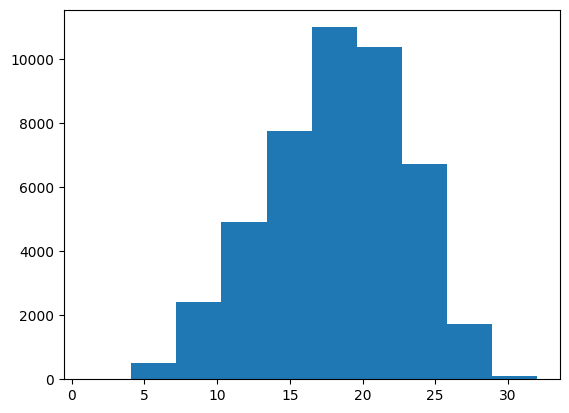

In [14]:
import matplotlib.pyplot as plt

rv_l = [len(doc) for doc in train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

We now need to choose a fixed sequence length, then *pad* the documents that are shorter than this maximum by adding a special token to the start of the sequence. The special pad token has an input value of 0. Any documents that exceed the length will be truncated.

**TO-DO 2a:** Complete the padding code below to insert 0s at the start of any sequences that are too short, and to truncate any sequences that are too long. **(3 marks)**

In [15]:
sequence_length = 40  # truncate all docs longer than this. Pad all docs shorter than this.
pad_token_id = 0

def pad_text(sample):
    ###WRITE YOUR OWN CODE HERE
    # if (len(sample['text']) < sequence_length):
    #     sample['text'] = sample['text'].rjust(sequence_length, '0')
    # if (len(sample['text']) > sequence_length):
    #     sample['text'] = sample['text'][:40]

    # if (len(sample['input_ids']) < sequence_length):
    #     padding_length = sequence_length - len(sample['input_ids'])
    #     sample['input_ids'] = ['0'] * padding_length + sample['input_ids']
    
    # if (len(sample['input_ids']) > sequence_length):
    #     sample['input_ids'] = sample['input_ids'][:40]
    # ##########

    # # sample = {'text':sample['text'], 'label':sample['label'], 'input_ids':sample['input_ids']}
    
    # return sample

    text = sample['text']
    input_ids = sample['input_ids']
    label = sample['label']
    
    # truncate any sequences that are too long
    if len(input_ids) > sequence_length:
        input_ids = input_ids[:sequence_length]
    
    # pad any sequences that are too short
    if len(input_ids) < sequence_length:
        padding_length = sequence_length - len(input_ids)
        input_ids = [pad_token_id] * padding_length + input_ids
    
    # create a new dictionary with the padded/truncated sequence and return it
    padded_sample = {'text': text, 'label': label, 'input_ids': input_ids}
    return padded_sample    

# The map method will call pad_text for every document in the dataset
train_dataset = train_dataset.map(pad_text)

Loading cached processed dataset at /mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a17b7df5edfb4da8.arrow


We now have our data in almost the right format! To train a model using PyTorch, we are going to wrap our dataset in a [DataLoader object](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). This allows the training process to select random subsets of the dataset -- mini-batches -- which it will use for learning with mini-batch stochastic gradient descent.

In [16]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# convert from the Huggingface format to a TensorDataset so we can use the mini-batch sampling functionality
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    # input_tensor = torch.from_numpy(np.array([item for sublist in train_dataset['input_ids'] for item in sublist]))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

num_classes = len(np.unique(train_labels))   # number of possible labels in the sentiment analysis task

train_loader = convert_to_data_loader(train_dataset, num_classes)

Let's process the development and test set as well.

In [17]:
dev_dataset = dev_dataset.map(encode_text)
dev_dataset = dev_dataset.map(pad_text)
dev_loader = convert_to_data_loader(dev_dataset, num_classes)

test_dataset = test_dataset.map(encode_text)
test_dataset = test_dataset.map(pad_text)
test_loader = convert_to_data_loader(test_dataset, num_classes)

Loading cached processed dataset at /mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-05659c67a7f822c7.arrow
Loading cached processed dataset at /mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-712295d61e698670.arrow
Loading cached processed dataset at /mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-845be0dc551ecfa5.arrow
Loading cached processed dataset at /mnt/d/Data Science MSc/Advanced DA/Week 22/advanced-labs-public/data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-7a8a77a0513571e3.arrow


As shown in the diagram above, we will build a NN with three different layers for sentiment classification.

### Embedding layer
In the embedding layer, the network will create its own embeddings for the index with a given embedding dimension.
The module `nn.Embedding()` creates a simple lookup table that stores embeddings of a fixed dictionary and size.
This module is often used to store word embeddings and retrieve them using indices.
The module's input is a list of indices, and the output is the corresponding word embeddings.

[Documentation for Embedding Class](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

### Fully-connected layer
Fully-connected layers in a neural network are those layers where all the inputs from the previous layer are connected to every unit of the fully-connected layer. Here we will use fully-connected layers for the hidden layer and output layer. In Pytorch this kind of layer is implemented by the 'Linear' class:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

## Activation functions
In Pytorch, the activation function is not included in the Linear class (or other kinds of neural network layer), so we need to explicitly connect each layer to an activation function.
In Pytorch, we construct a neural network by connecting up the output of each component to the input of the next, thereby creating a computation graph.
To complete the hidden layer, we connect the ouput of the linear layer to a ReLU activation function, thereby creating a nonlinear function.

The cell below defines a class for our neural text classifier. The constructor creates each of the layers and the activations. The dimensions of each layer need to be correct so that the output of one layer can be passed as input to the next, but the code is not yet complete.

Below the constructor is the forward method. This is called in the 'forward pass' to map the neural network's inputs to its outputs. In PyTorch, we pass data through each layer of the model, connecting them together, then returning the output of the final layer.

**TO-DO 2b** Complete the constructor and the forward method below for a NN with three layers. The places where you need to add code are marked in the cell below. Refer to the Pytorch documentation for additional help.  **(2 marks)**

In [18]:
from torch import nn

class FFTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, sequence_length, embedding_size, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) # embedding layer
        
        ### COMPLETE THE CODE HERE: WRITE IN THE MISSING ARGUMENTS SPECIFYING THE DIMENSIONS OF EACH LAYER
        self.hidden_layer = nn.Linear(sequence_length * embedding_size, hidden_size) # Fully connected hidden layer
        self.activation = nn.ReLU() # Hidden layer
        ##########
        
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected output layer

        
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size

        z = self.hidden_layer(embedded_words)   # (batch_size, seq_length, hidden_size)
        
        ### ADD THE MISSING LINE HERE
        h = self.activation(z)
        ########

        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

Now the class is complete. 

TO-DO 2c: In the next cell, create a NN with the FFTextClassifier class we wrote. (unmarked)

Hint: `ff_classifier_model = FFTextClassifier(...)`

In [19]:
vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 10  # number of dimensions for embeddings
hidden_size = 8 # number of hidden units

###WRITE YOUR OWN CODE HERE
ff_classifier_model = FFTextClassifier(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    num_classes=3
)

After desigining our network, we need to create a training function to calculate the loss for each input and perform backpropagation to optimise the network.
During training, the weights of all the layers will be updated.

Below, we build a training function to train the NN over a fixed number of epochs (an epoch is one iteration over the whole training dataset).
The function also prints the performance of both training and development/validation set after each epoch.

Here we use cross-entropy loss, which is the standard loss function for classification that we also used for logistic regression. The module `nn.CrossEntropyLoss()` operates directly on the output of our output layer, so we don't have to implement the softmax layer within the forward() method.

Cross Entropy Loss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

The optimizer object implements a particular algorithm for updating the weights. Here, we will use the Adam optimizer, which is a variant of stochastic gradient descent method that tends to find a better solution in a smaller number of iterations than standard SGD.

Optimization: https://pytorch.org/docs/stable/optim.html

The cell below defines a training function for our classifier:

In [20]:
from torch import optim

def train_nn(num_epochs, model, train_dataloader, dev_dataloader):
    
    learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
        
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        # Compute accuracy on dev set after this training epoch
        
        model.eval()  # Switch model to evaluation mode - turn off any random steps such as dropout
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_labels in dev_dataloader:
            
            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))

    return model

**TO-DO 2d:** Modify the training function above to return the training and development (or 'validation') losses at each epoch. Train the network for 15 epochs and plot the losses. Describe what the plot shows, and how you could use this information to improve the training process. **(8 marks)**

<span style="color:yellow">
The plot shows the training and validation losses over each epoch of training. It seems that the model is able to reduce the training loss over time, but the validation loss starts to plateau and even increase slightly after a few epochs. This suggests that the model is starting to overfit to the training data and is not generalizing well to the validation set.
<br>

To address this, several strategies could be used. One approach is to add regularization to the model, such as dropout or weight decay, which can help to prevent overfitting. Another approach is to collect more training data or use data augmentation techniques to increase the diversity of the training set. Additionally, tuning the hyperparameters of the model, such as the learning rate or the size of the hidden layer, could also help to improve performance.
<br>

It is also important to monitor the training and validation losses over time, as this can help to detect overfitting or other issues with the training process. If the validation loss starts to increase, it may be necessary to stop training early or adjust the model or hyperparameters to improve performance.
</span>


In [21]:
###WRITE YOUR OWN CODE HERE
from torch import optim

train_losses_mean = []
dev_losses_mean = []

def train_nn(num_epochs, model, train_dataloader, dev_dataloader):
    
    learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
        
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100
        train_losses_mean.append(np.mean(train_losses))

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        # Compute accuracy on dev set after this training epoch
        
        model.eval()  # Switch model to evaluation mode - turn off any random steps such as dropout
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_labels in dev_dataloader:

            dev_output = model(dev_input_ids)
            dev_loss = loss_fn(dev_output, dev_labels)
            dev_losses.append(dev_loss.item())
            
            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        dev_losses_mean.append(np.mean(dev_losses))

        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))

    return model

In [22]:
trained_model = train_nn(15, ff_classifier_model, train_loader, dev_loader)

Epoch: 1/15 Training Loss: 1.0126 Training Accuracy: 44.9019%
Epoch: 1/15 Validation Loss: 1.0232 Validation Accuracy: 43.7000%
Epoch: 2/15 Training Loss: 0.9984 Training Accuracy: 46.8179%
Epoch: 2/15 Validation Loss: 1.0048 Validation Accuracy: 45.4500%
Epoch: 3/15 Training Loss: 0.9755 Training Accuracy: 50.2861%
Epoch: 3/15 Validation Loss: 0.9776 Validation Accuracy: 49.5500%
Epoch: 4/15 Training Loss: 0.9401 Training Accuracy: 53.7499%
Epoch: 4/15 Validation Loss: 0.9595 Validation Accuracy: 52.4500%
Epoch: 5/15 Training Loss: 0.9035 Training Accuracy: 56.5362%
Epoch: 5/15 Validation Loss: 0.9448 Validation Accuracy: 53.8500%
Epoch: 6/15 Training Loss: 0.8721 Training Accuracy: 58.6540%
Epoch: 6/15 Validation Loss: 0.9289 Validation Accuracy: 55.8000%
Epoch: 7/15 Training Loss: 0.8442 Training Accuracy: 60.5437%
Epoch: 7/15 Validation Loss: 0.9141 Validation Accuracy: 56.3000%
Epoch: 8/15 Training Loss: 0.8187 Training Accuracy: 62.0235%
Epoch: 8/15 Validation Loss: 0.9042 Valida

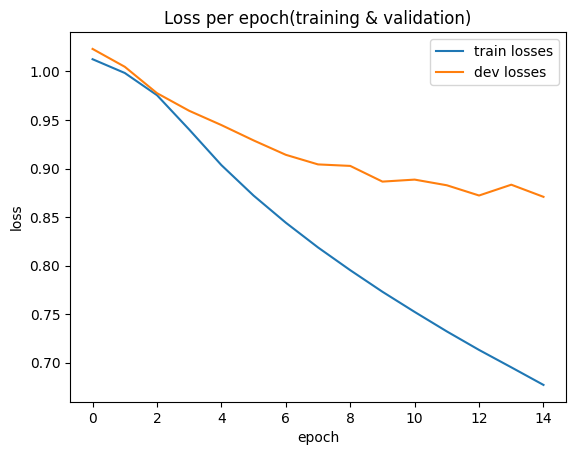

In [23]:
plt.plot(train_losses_mean, label = 'train losses')
plt.plot(dev_losses_mean, label = 'dev losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss per epoch(training & validation)')
plt.legend()

The code below obtains predictions from our neural network:

In [24]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()  # switch off some randomisation used during training (dropout) to give consistent predictions

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, labels in test_loader:
        test_output = trained_model(inputs)  # run the forward() function on the inputs
        predicted_labels = test_output.argmax(1)  # select the class labels with highest logits as our predictions

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

gold_labs, pred_labs = predict_nn(trained_model, test_loader)

In [25]:
# f1-score calculation
from sklearn.metrics import f1_score
f1_score_nn = f1_score(gold_labs, pred_labs, average='weighted')
print(f"F1 score with neural network: {f1_score_nn}")

F1 score with neural network: 0.5185213249892008


Now, we can use pretrained word embeddings instead of learning them from scratch during training.
Here, we will use the pretrained GloVe embeddings that we loaded before. The embedding matrix is used to initialise the embedding layer. The code below converts the GloVe embeddings into an embedding matrix suitable for PyTorch:

In [26]:
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])
        
print(embedding_matrix)

/tmp/ipykernel_244/225966899.py:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.3535,  0.0987,  0.1718,  ...,  0.4630,  1.3101,  1.1314],
        [-0.4106,  0.1487,  0.0637,  ...,  0.6097,  1.0935,  0.9614],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


The class below extends the FFTextClassifier class (it's incomplete for now -- you'll fix this in a minute!). This means that it inherits all of its functionality, but we overwrite the constructor (the `__init__` method). This way, we don't need to define the forward function again, as it will be the same as before.

The embedding layer is now different as it loads pretrained embeddings from our matrix. The argument `freeze` determines whether the embeddings remain fixed to their pretrained values (if `freeze=True`) or are updated through backpropagation to fit them to the dataset.

In [27]:
class FFTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True) # embedding layer

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(self.embedding_size * sequence_length, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer activation
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected layer

**TO-DO 2e:** Complete the arguments in the `FFTextClassifierWithEmbeddings` constructor to set the dimensions of the neural network layers.  Repeat the experiment above using the FFTextClassifierWithEmbeddings with the GLoVe embeddings. Choose a suitable performance metric and compare the performance of the two neural text classifiers. Explain in one or two sentences the possible reason(s) for any performance differences you observe. **(3 marks)**

WRITE YOUR ANSWER HERE:

In [28]:
### WRITE YOUR OWN CODE BELOW
ff_classifier_with_embeddings_model = FFTextClassifierWithEmbeddings(
    hidden_size=hidden_size, 
    sequence_length=sequence_length,  
    num_classes =3, 
    embedding_matrix=embedding_matrix
)

trained_ff_classifier_with_embeddings_model = train_nn (
    15, ff_classifier_with_embeddings_model, train_loader, dev_loader
)

Epoch: 1/15 Training Loss: 1.0086 Training Accuracy: 46.3159%
Epoch: 1/15 Validation Loss: 0.9912 Validation Accuracy: 48.6000%
Epoch: 2/15 Training Loss: 0.9765 Training Accuracy: 49.3127%
Epoch: 2/15 Validation Loss: 0.9921 Validation Accuracy: 48.3500%
Epoch: 3/15 Training Loss: 0.9668 Training Accuracy: 50.0340%
Epoch: 3/15 Validation Loss: 0.9864 Validation Accuracy: 48.0000%
Epoch: 4/15 Training Loss: 0.9592 Training Accuracy: 50.6281%
Epoch: 4/15 Validation Loss: 0.9924 Validation Accuracy: 48.0000%
Epoch: 5/15 Training Loss: 0.9531 Training Accuracy: 51.0512%
Epoch: 5/15 Validation Loss: 0.9971 Validation Accuracy: 47.5000%
Epoch: 6/15 Training Loss: 0.9477 Training Accuracy: 51.5861%
Epoch: 6/15 Validation Loss: 0.9967 Validation Accuracy: 47.4500%
Epoch: 7/15 Training Loss: 0.9428 Training Accuracy: 52.0794%
Epoch: 7/15 Validation Loss: 0.9970 Validation Accuracy: 47.5500%
Epoch: 8/15 Training Loss: 0.9386 Training Accuracy: 52.3161%
Epoch: 8/15 Validation Loss: 1.0051 Valida

The F1 score with `FFTextClassifier` is 0.53 and the F1 score with `FFTextClassifierWithEmbeddings` is 0.38. So, it is evident that using pre-trained embeddings did not improve the performance of the neural text classifier. 
<br><br>
One of the reasons of this happening could be that pre-trained embeddings may have captured more nuanced and sophisticated word representations than the embeddings learned from scratch during training making it perform bad.

In [29]:
y_pred_with_emeddings, y_true_with_emeddings = predict_nn(trained_ff_classifier_with_embeddings_model, test_loader)

f1_score_embeddings = f1_score(y_pred_with_emeddings, y_true_with_emeddings, average='weighted')
print(f"F1 score with GloVe embeddings: {f1_score_embeddings}")

F1 score with GloVe embeddings: 0.39662731576049487


# 3. Improving the Neural Text Classifier (max. 22 marks)

This section allows you some more free reign to experiment with the neural text classifier. Below, we list several to-dos that you can solve in your own way. Please make sure to label your notebook cells clearly so that it is obvious which to-do each cell corresponds to.

**TO-DO 3a:** Consider the neural text classifiers we have just implemented and the results you obtained in the last to-do. The classifiers have a number of limitations that we could improve. Describe three limitations and how you could improve them. For each improvement you propose, provide a brief explanation (up to 1 paragraph) of how it works. 

Hint: refer to the lectures for some ideas. **(9 marks)**

WRITE YOUR ANSWER HERE:


---

**TO-DO 3b:** Implement your improvements and compute the performance of your method. Make sure to comment your code to show where each new step is implemented. Use the validation set for any tuning you decide to do. Present your results clearly. **(13 marks)**

In [30]:
# TO-DO 3b
n_layers = 1
class RNNTextClassifier(nn.Module):
    def __init__(self, hidden_size, sequence_length, num_classes, embedding_size):
        super(RNNTextClassifier, self).__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length

        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.rnn_layer = nn.RNN(
            input_size = embedding_size,
            hidden_size = hidden_size,
            num_layers = 3,
            batch_first = True,
            nonlinearity = 'relu',
            dropout = 0.2)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_words):
        embedded_words = self.embedding_layer(input_words)
        rnn_input = embedded_words.view(-1, self.sequence_length, self.embedding_size)
        rnn_output, _ = self.rnn_layer(rnn_input)
        rnn_output = rnn_output[:, -1, :]
        activation_output = self.activation(rnn_output)
        logits = self.output_layer(activation_output)
        
        return logits

In [31]:
vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 15  # number of dimensions for embeddings
hidden_size = 10 # number of hidden units

rnn_classifier_model = RNNTextClassifier(
    hidden_size=hidden_size, 
    sequence_length=sequence_length,
    num_classes=3,
    embedding_size=embedding_size
)

trained_rnn_classifier_model = train_nn(
    20, rnn_classifier_model, train_loader, dev_loader
)

Epoch: 1/20 Training Loss: 1.0502 Training Accuracy: 41.8722%
Epoch: 1/20 Validation Loss: 1.0192 Validation Accuracy: 43.5500%
Epoch: 2/20 Training Loss: 1.0119 Training Accuracy: 45.2812%
Epoch: 2/20 Validation Loss: 1.0141 Validation Accuracy: 43.8000%
Epoch: 3/20 Training Loss: 1.0039 Training Accuracy: 45.3250%
Epoch: 3/20 Validation Loss: 0.9992 Validation Accuracy: 43.9000%
Epoch: 4/20 Training Loss: 0.9860 Training Accuracy: 45.9235%
Epoch: 4/20 Validation Loss: 0.9747 Validation Accuracy: 46.8500%
Epoch: 5/20 Training Loss: 0.9587 Training Accuracy: 48.4336%
Epoch: 5/20 Validation Loss: 0.9662 Validation Accuracy: 49.5500%
Epoch: 6/20 Training Loss: 0.9272 Training Accuracy: 51.6804%
Epoch: 6/20 Validation Loss: 0.9296 Validation Accuracy: 52.8500%
Epoch: 7/20 Training Loss: 0.8998 Training Accuracy: 54.5961%
Epoch: 7/20 Validation Loss: 0.9111 Validation Accuracy: 54.8500%
Epoch: 8/20 Training Loss: 0.8715 Training Accuracy: 57.3496%
Epoch: 8/20 Validation Loss: 0.8959 Valida

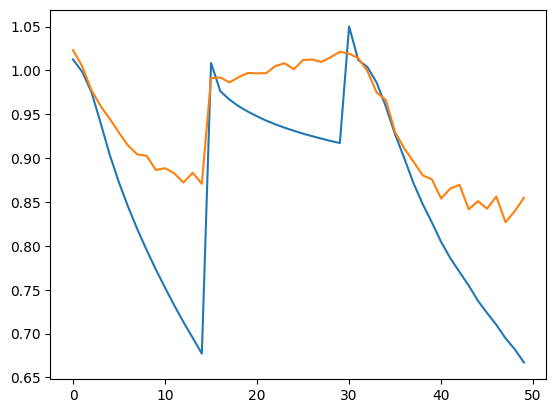

In [32]:
plt.plot(train_losses_mean)
plt.plot(dev_losses_mean)

In [39]:
embedding_size = 20
hidden_size1 = 10
hidden_size2 = 15
hidden_size3 = 20
n_layers = 1

class  MultiRNNTextClassifier(nn.Module):
    def __init__(self, hidden_size, sequence_length, num_classes, embedding_size):
        super(MultiRNNTextClassifier, self).__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size1
        self.sequence_length = sequence_length

        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.rnn1 = nn.RNN(embedding_size, hidden_size = hidden_size1, num_layers = 1, batch_first = True)
        self.rnn2 = nn.RNN(hidden_size1, hidden_size = hidden_size2, num_layers = 1, batch_first = True)
        self.rnn3 = nn.RNN(hidden_size2, hidden_size = hidden_size3, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(hidden_size3, num_classes)

    def forward(self, input_words):
        embedded_words = self.embedding_layer(input_words)
        output_rnn1, _ = self.rnn1(embedded_words)
        output_rnn2, _ = self.rnn2(output_rnn1)
        output_rnn3, _ = self.rnn3(output_rnn2)
        last_output = output_rnn3[:, -1, :]
        logits = self.linear(last_output)

        return logits

In [40]:
multi_rnn_classifier_model = MultiRNNTextClassifier(
    hidden_size=hidden_size,
    sequence_length=sequence_length,
    num_classes=3,
    embedding_size=20
)

trained_multi_rnn_classsifier_model = train_nn(
    15, multi_rnn_classifier_model, train_loader, dev_loader
)

Epoch: 1/15 Training Loss: 1.0150 Training Accuracy: 45.3228%
Epoch: 1/15 Validation Loss: 1.0132 Validation Accuracy: 44.2000%
Epoch: 2/15 Training Loss: 0.9954 Training Accuracy: 49.1132%
Epoch: 2/15 Validation Loss: 1.0014 Validation Accuracy: 48.0000%
Epoch: 3/15 Training Loss: 0.9592 Training Accuracy: 52.8620%
Epoch: 3/15 Validation Loss: 0.9763 Validation Accuracy: 51.4500%
Epoch: 4/15 Training Loss: 0.9186 Training Accuracy: 56.1263%
Epoch: 4/15 Validation Loss: 0.9480 Validation Accuracy: 54.6000%
Epoch: 5/15 Training Loss: 0.8791 Training Accuracy: 59.1998%
Epoch: 5/15 Validation Loss: 0.9148 Validation Accuracy: 57.0000%
Epoch: 6/15 Training Loss: 0.8430 Training Accuracy: 61.3811%
Epoch: 6/15 Validation Loss: 0.9016 Validation Accuracy: 58.3500%
Epoch: 7/15 Training Loss: 0.8106 Training Accuracy: 63.4046%
Epoch: 7/15 Validation Loss: 0.8888 Validation Accuracy: 59.0500%
Epoch: 8/15 Training Loss: 0.7824 Training Accuracy: 64.9370%
Epoch: 8/15 Validation Loss: 0.8803 Valida

In [62]:
import torch.nn.functional as F

class LSTMTextClassifier(nn.Module):
    def __init__(self, hidden_size, sequence_length, num_classes, embedding_size):
        super(LSTMTextClassifier, self).__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length

        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(input_size = embedding_size,
                            hidden_size = hidden_size,
                            num_layers = 1, 
                            batch_first = True, 
                            bidirectional = True)
        self.drop = nn.Dropout(p = 0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input_words):
        embedded_words = self.embedding_layer(input_words)
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded_words,
        #                                                     input_words.shape[1], batch_first=True)
        # packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)
        
        # # Concatenating the final forward and backward hidden states
        # hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        # dense_outputs=self.fc(hidden)
        # outputs = self.sigmoid(dense_outputs)
        output_lstm, _ = self.lstm(embedded_words)
        last_output = output_lstm[:, -1, :]
        logits = self.fc(last_output)

        return logits       


In [65]:
vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 20  # number of dimensions for embeddings
hidden_size = 10 # number of hidden units

lstm_classifier_model = LSTMTextClassifier(
    hidden_size=hidden_size,
    sequence_length=sequence_length,
    num_classes=3,
    embedding_size=embedding_size
)

trained_lstm_classifier_model = train_nn(
    20, lstm_classifier_model, train_loader, dev_loader
)

Epoch: 1/20 Training Loss: 1.0192 Training Accuracy: 44.4569%
Epoch: 1/20 Validation Loss: 1.0131 Validation Accuracy: 45.3500%
Epoch: 2/20 Training Loss: 0.9948 Training Accuracy: 47.9053%
Epoch: 2/20 Validation Loss: 0.9908 Validation Accuracy: 47.2500%
Epoch: 3/20 Training Loss: 0.9574 Training Accuracy: 51.6738%
Epoch: 3/20 Validation Loss: 0.9687 Validation Accuracy: 49.1500%
Epoch: 4/20 Training Loss: 0.9124 Training Accuracy: 55.6308%
Epoch: 4/20 Validation Loss: 0.9362 Validation Accuracy: 52.0500%
Epoch: 5/20 Training Loss: 0.8688 Training Accuracy: 58.7482%
Epoch: 5/20 Validation Loss: 0.9114 Validation Accuracy: 55.4000%
Epoch: 6/20 Training Loss: 0.8294 Training Accuracy: 61.3855%
Epoch: 6/20 Validation Loss: 0.8918 Validation Accuracy: 58.2000%
Epoch: 7/20 Training Loss: 0.7947 Training Accuracy: 63.3783%
Epoch: 7/20 Validation Loss: 0.8720 Validation Accuracy: 58.7500%
Epoch: 8/20 Training Loss: 0.7625 Training Accuracy: 65.4609%
Epoch: 8/20 Validation Loss: 0.8564 Valida

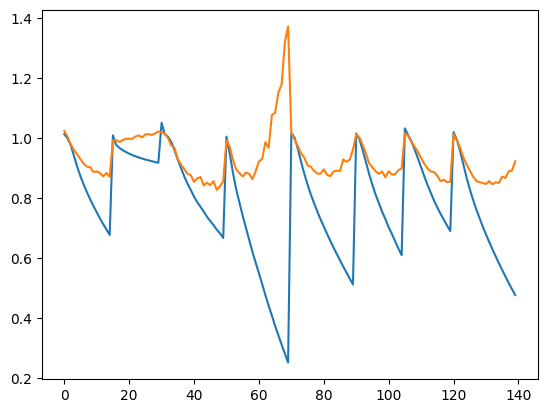

In [66]:
plt.plot(train_losses_mean)
plt.plot(dev_losses_mean)